# 1. import libraries

In [24]:
from datetime import date, timedelta                    # look for posts from each day
import requests                                         # send HTTP requests to get HTML from webpages
from bs4 import BeautifulSoup                           # search HTML from webpages
from time import sleep                                  # give the server a pause between requests
import pandas as pd                                     # convert data into dataframe
from google.colab import files                          # download csv file
%matplotlib inline
import matplotlib.pyplot as plt                         # create scatterplot
import seaborn as sns                                   # create scatterplot
import numpy as np                                      # create histogram

# 2. scrape data

### initialize lists

In [2]:
# loop through dates to create all initial urls for the last year
dates = []

# loop through urls to create array of all posts per day, for the last year
urls_list = []

### find the url for our data from the following website: https://statmodeling.stat.columbia.edu/

In [25]:
url = "https://statmodeling.stat.columbia.edu/"

year = input("Enter your year: ")
year = int(float(year))

start_date = date(year, 1, 1)                           # set first day of the desired time period
end_date = date(year, 12, 31)                           # set last day of the desired time period

delta = end_date-start_date                             # 365 days

for i in range(delta.days+1):                           # range(0, 365)
  day = start_date + timedelta(days=i)                  # 2021-01-01, 2021-01-02, 2021-01-03
  date_string = day.strftime("%Y/%m/%d")                # convert to 2021/01/01, 2021/01/02, 2021/01/03
  dates.append(date_string)

for date in dates:
  initial_url = url + date                              # https://statmodeling.stat.columbia.edu/2021/01/01
  urls_list.append(initial_url)                         # ['https://statmodeling.stat.columbia.edu/2021/01/01, ]

Enter your year: 2023
2023


### collect names of commenters, comment counts, unique number of commenters per post

In [4]:
# create a dictionary to store all commenter names and counts for one post
commenters = {}
# create a list to store post title, post date, unique commenter count, and URL
unique_commenters = []

def count(all_comments, title, date, url):
  # create a dictionary that tracks unique commenters
  unique_commenters_for_one_post = {}

  for comment in all_comments:
    # find the commenter's name
    commenter_name = comment.find("span", {"class": "fn"}).text
                                                        # looks inside <span class="fn"><a class="url" href="https://twitter.com/JaneSmith" rel="external nofollow ugc">Jane Smith</a></span>
                                                        # for Jane Smith

    if commenter_name in unique_commenters_for_one_post:
      unique_commenters_for_one_post[commenter_name] += 1
    else:
      unique_commenters_for_one_post[commenter_name] = 1
                                                        # { 'Jane Smith': 1, 'Jane Doe': 2, }

  unique_commenters.append([
                            title,                      # What we did in 2020, and thanks to all our collaborators and many more
                            date,                       # 2021-01-01T09:00:09-05:00
                            len(unique_commenters_for_one_post.keys()),
                                                        # how many unique commenters there were on this post: 12
                            url                         # 'https://statmodeling.stat.columbia.edu/2021/01/01/what-we-did-in-2020/#comments'
                            ])

  commenters[url] = unique_commenters_for_one_post
  # print(commenters)
                                                        # { {'Jane Smith': 1, 'Jane Doe': 2, } }

def get_data_from_post(all_posts):
  for post in all_posts:
    # grab the actual link(s) for all post(s) made on one day
    url_we_want = post.find("a").get("href")            # https://statmodeling.stat.columbia.edu/2021/01/01/what-we-did-in-2020/#comments

    # grab one post's content
    url_we_want_get = requests.get(url_we_want, headers = headers)
    one_post_html= BeautifulSoup(url_we_want_get.text, "html.parser")

    # grab the post's title, date, and comments
    post_title = one_post_html.find("h1", {"class": "entry-title"}).text

    post_date = one_post_html.find("time", {"class": "entry-date"}).get("datetime")[0:10]
                                                        # 2021-01-01

    # find all the comment(s) for one post
    all_comments_one_post = one_post_html.findAll("div", {"class": "comment-author vcard"})
                                                        # [<div class="comment-author vcard">
                                                        # <img alt="" class="avatar avatar-68 photo" height="68" loading="lazy" src="https://secure.gravatar.com/avatar/4ca887fa9f168857d43ef5eb3c636296?s=68&amp;d=mm&amp;r=g" srcset="https://secure.gravatar.com/avatar/4ca887fa9f168857d43ef5eb3c636296?s=136&amp;d=mm&amp;r=g 2x" width="68"/><span class="fn"><a class="url" href="https://twitter.com/JaneSmith" rel="external nofollow ugc">Jane Smith</a></span> on <a href="https://statmodeling.stat.columbia.edu/2021/01/01/what-we-did-in-2020/#comment-1630101"><time datetime="2021-01-01T09:16:18-05:00">January 1, 2021 9:16 AM at 9:16 am</time></a> <span class="says">said:</span>
                                                        # </div>, <div class="comment-author vcard">

    count(all_comments_one_post, post_title, post_date, url_we_want)

# check every day of the year with a potential post
for url in urls_list:
  # to avoid the error message from the site. Change if you're not using Chrome.
  headers = {
      "user-agent": "Chrome/88.0.4324.182"
      }
  site_get = requests.get(url, headers = headers)
  # sleep(0.5)                                          # x-second pause between requests
  site_html= BeautifulSoup(site_get.text, "html.parser")

  # find the comment button(s) for all post(s) made on one day
  all_post_urls= site_html.findAll("span", {"class":"comments-link"})
                                                        # [<span class="comments-link"><a href="https://statmodeling.stat.columbia.edu/2021/01/05/authors-retract-the-nature-communications-paper-on-female-mentors/#comments"><b>15</b> Replies</a></span>, ]
  get_data_from_post(all_post_urls)


# 3. create csvs

In [26]:
def convert_to_csv_and_download(dataframe, csv_file):
  # convert to csv
  with open(csv_file, 'w') as f:
    dataframe.to_csv(
      f,
      header = True,
      index=False
      )

  # download the csv
  files.download(csv_file)

In [27]:
# create first csv

# convert to a pandas dataframe
unique_commenters_df = pd.DataFrame(
  unique_commenters,
  columns= [
            "Post Title",
            "Post Date",
            "Unique Commenters",
            "URL"
            ])

# use the year to title your csv file
file_title = str(year) + '_blog.csv'
convert_to_csv_and_download(unique_commenters_df, file_title)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# create a dictionary for the commenter's total response rate
total_comments = {}

# create a dictionary for the number of distinct posts the commenter wrote on
unique_posts = {}

all_commenters = []

for commenters_dict in commenters.values():
  for commenter in commenters_dict.keys():

    # { 'Jane Smith': 286, 'Jane Doe': 1089, }
    if commenter in total_comments:
        total_comments[commenter] += commenters_dict[commenter]
    else:
        total_comments[commenter] = commenters_dict[commenter]

    # { 'Jane Smith': 88, 'Jane Doe': 162, }
    if commenter in unique_posts:
        unique_posts[commenter] += 1
    else:
        unique_posts[commenter] = 1

for commenter in total_comments.keys():
  all_commenters.append([
                      commenter,                        # Jane Smith
                      total_comments[commenter],        # 286
                      unique_posts[commenter]           # 88
                      ])

In [30]:
# create second csv

# convert to a pandas dataframe
commenters_df = pd.DataFrame(
  all_commenters,
  columns= [
            "Commenter",
            "Total Response Rate",
            "Number of Posts"
            ])

# set the year to title your csv file
csv_file = str(year) + '_commenters.csv'

convert_to_csv_and_download(commenters_df, csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. create graphs

### create a histogram

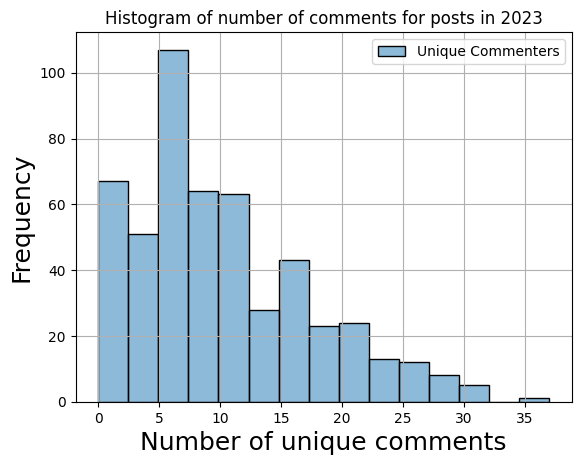

In [32]:
# create a histogram

sns.histplot(unique_commenters_df.iloc[:, [2]])
plt.xlabel('Number of unique comments', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title("Histogram of number of comments for posts in " + str(year))
plt.grid(True)

plt.show()

### create a scatterplot

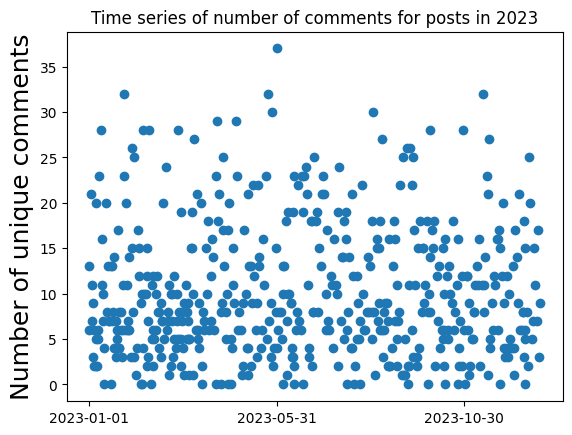

In [31]:
# create a scatterplot

# create data
N = len(unique_commenters_df)                           # number of data points
x = unique_commenters_df.iloc[:, 1]                     # date column
y = unique_commenters_df.iloc[:, 2]                     # unique commenters column

# give the x-axis 3 ticks
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))

# plot the data
plt.scatter(x, y)
plt.ylabel('Number of unique comments', fontsize=18)
plt.title("Time series of number of comments for posts in " + str(year))

plt.show()

In [11]:
unique_commenters_df

,Post Title,Post Date,Unique Commenters,URL
0,How to model a non-monotonic relation?,2023-01-01,13,https://statmodeling.stat.columbia.edu/2023/01...
1,Yo-Yo Ma (1) vs. Li Wenwen; Hill advances,2023-01-01,6,https://statmodeling.stat.columbia.edu/2023/01...
2,Challenge of expressing uncertainty in scienti...,2023-01-02,21,https://statmodeling.stat.columbia.edu/2023/01...
3,Explanation and reproducibility in data-driven...,2023-01-03,11,https://statmodeling.stat.columbia.edu/2023/01...
4,The interaction between predatory journals and...,2023-01-03,7,https://statmodeling.stat.columbia.edu/2023/01...
...,...,...,...,...
504,Uh oh Barnard . . .,2023-12-27,11,https://statmodeling.stat.columbia.edu/2023/12...
505,Judgments versus decisions,2023-12-28,7,https://statmodeling.stat.columbia.edu/2023/12...
506,Hey wassup Detroit Pistons? What’s gonna happ...,2023-12-29,17,https://statmodeling.stat.columbia.edu/2023/12...
507,“How not to be fooled by viral charts”,2023-12-30,3,https://statmodeling.stat.columbia.edu/2023/12...
